In [1]:
import warnings
warnings.filterwarnings('ignore')
from data_generator import *
from data_augmentation import aug_with_crop
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
from keras.models import load_model

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
train_generator = DataGeneratorFolder(image_path='../../data/training/images', 
                                      mask_path='../../data/training/groundtruth', 
                                      batch_size=4,  
                                      nb_y_features=1, 
                                      augmentation=None)
print(len(train_generator))

test_generator = DataGeneratorFolder(image_path='../../data/training/test_images',
                                     mask_path='../../data/training/test_groundtruth',
                                     batch_size=4,
                                     nb_y_features=1)
print(len(test_generator))


13
13


In [3]:
class my_model:
    def __init__(self, train_generator, test_generator):
        self.train_generator = train_generator
        self.test_generator = test_generator
        
    def initialize_callbacks(self):
        lr_reducer = ReduceLROnPlateau(
            factor=0.1, cooldown=10, patience=10, verbose=1, min_lr=0.1e-5)
        mode_autosave = ModelCheckpoint('./saved_models/saved.h5', monitor='val_iou_score',
                                        mode='max', save_best_only=True, verbose=1, period=1)
        early_stopping = EarlyStopping(patience=10, verbose=1, mode='auto')
        tensorboard = TensorBoard(log_dir='./logs/tensorboard', histogram_freq=0,
                                  write_graph=True, write_images=False)

        self.callbacks = [lr_reducer,
                          mode_autosave,
                          early_stopping,
                          tensorboard]

    def model_compile(self):
        self.model = Unet(backbone_name='efficientnetb0',
                          encoder_weights=None, encoder_freeze=False)
        self.model.compile(
            optimizer=Adam(), loss=bce_jaccard_loss, metrics=[iou_score])

    def model_fit(self):
        history = self.model.fit_generator(self.train_generator, 
                                           shuffle=False, 
                                           epochs=200, 
                                           workers=4,
                                           use_multiprocessing=True, 
                                           validation_data=self.test_generator,
                                           verbose=1, 
                                           callbacks=self.callbacks,

                                          )
        self.history = history

    def plot_training_history(self):

        plt.plot(self.history.history["loss"])
        plt.plot(self.history.history["val_loss"])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('model loss')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        plt.plot(self.history.history["iou_score"])
        plt.plot(self.history.history["val_iou_score"])
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('model accuracy')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    
    def plot_mask_gt_image(self, mask, groud_truth, img):
        fig, axs = plt.subplots(1,3, figsize=(20,10))
        axs[0].imshow(mask[0].squeeze(-1), cmap="Blues")
        axs[1].imshow(groud_truth, cmap="Blues")
        axs[2].imshow(img)
        plt.show()

    def model_load(self, path):
        self.model = load_model(path, compile=False)

    def predict(self, image):
        return self.model.predict(np.expand_dims(image, axis=0))
    

In [4]:
u_net_model = my_model(train_generator, test_generator)
print('Model initiated')

u_net_model.initialize_callbacks()

print('callbacks created')

u_net_model.model_compile()

print('Model compiled')

print('Model start fitting')

u_net_model.model_fit()

print('Model fitted')

Model initiated
callbacks created
Instructions for updating:
Colocations handled automatically by placer.
Model compiled
Model start fitting
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
13/13 [==============================] - 141s 11s/step - loss: 1.0798 - iou_score: 0.5311 - val_loss: 0.2834 - val_iou_score: 0.9596

Epoch 00001: val_iou_score improved from -inf to 0.95956, saving model to ./saved_models/saved.h5
Epoch 2/200
13/13 [==============================] - 117s 9s/step - loss: 1.1344 - iou_score: 0.4503 - val_loss: 0.7943 - val_iou_score: 0.3961

Epoch 00002: val_iou_score did not improve from 0.95956
Epoch 3/200
13/13 [==============================] - 127s 10s/step - loss: 1.0026 - iou_score: 0.4620 - val_loss: 0.1816 - val_iou_score: 0.9016

Epoch 00003: val_iou_score did not improve from 0.95956
Epoch 4/200
13/13 [==============================] - 129s 10s/step - loss: 0.2947 - iou_score: 0.8823 - val_loss: -0.5086 - val_iou_score: 0.8476

Epoch 00004: val_

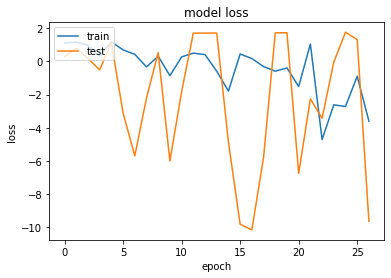

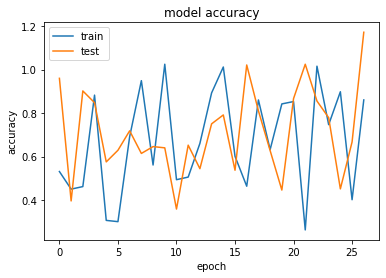

In [5]:
u_net_model.plot_training_history()

In [6]:
print(train_generator.image_filenames[0])

../../data/training/images/satImage_001.png


In [10]:
im_name = train_generator.image_filenames[0]
gr_name = train_generator.mask_filenames[0]
#im, gr = train_generator.read_image_mask(im_name, gr_name)
pred = u_net_model.predict(imread('../../data/test_set_images/test_1/test_1.png'))

In [11]:
print(pred.shape)
pred = np.squeeze(pred)
print(pred)

(1, 608, 608, 1)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


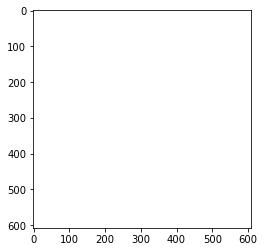

In [12]:
plt.figure()
plt.imshow(pred)